In [656]:
import deepctx as dc
from dnadb import fasta, taxonomy
from dnadb.sample import load_multiplexed_fasta
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import precision_recall_curve
from sklearn.manifold import MDS, TSNE
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm, trange
import wandb

In [2]:
import deepdna.nn.data_generators as dg
from deepdna.nn.models import load_model, setbert

In [3]:
dc.tf.devices.use(gpus=[0])

2023-11-18 09:57:17.775744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-11-18 09:57:17.775959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-18 09:57:17.781867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-18 09:57:17.782084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-18 09:57:17.782254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-18 09:57:17.782418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
api = wandb.Api()

In [749]:
path = api.artifact("sirdavidludwig/hopland/setbert-hopland-br-classifier-64d-150l:v0").download()
model = load_model(path)

wandb: Downloading large artifact setbert-hopland-br-classifier-64d-150l:v0, 53.21MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.2


In [753]:
model.model.layers

In [750]:
y = x = tf.keras.layers.Input(model.input_shape[1:])
embedding = model.model.layers[1](y)
output = model.model.layers[2](embedding)
embed = tf.keras.Model(x, (output, embedding))
embed.trainable = False

In [708]:
# embed.layers[1].base.model.layers[2].set_attention_attribution_enabled(False)

In [6]:
attribution = model.make_attribution_model()

2023-11-18 09:57:38.972817: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
samples = load_multiplexed_fasta(
    "/home/dwl2x/work/Datasets/Hopland/Hopland.fasta.db/",
    "/home/dwl2x/work/Datasets/Hopland/Hopland.fasta.mapping.db/",
    "/home/dwl2x/work/Datasets/Hopland/Hopland.fasta.index.db/"
)

In [557]:
outliers = ["Ur19-B-16S_S217_L001_R1_001", "Ur57-R-16S_S140_L001_R1_001"]
clean_samples = [s for s in samples if s.name not in outliers]
len(clean_samples)

126

In [441]:
taxonomy_labels = {e.identifier: e.label for e in taxonomy.entries("/home/dwl2x/work/Datasets/Hopland/Hopland.qiime.tax.tsv")}

In [442]:
len(taxonomy_labels)

1027593

In [8]:
len(samples)

128

In [9]:
def normalized(x):
    return x / np.abs(np.max(x))

In [10]:
output_path = Path("/home/data2/deepdna/logs/hopland/attribution")
output_path.mkdir(exist_ok=True, parents=True)

In [15]:
for s in tqdm(samples):
    sample_name = s.name
    bulk_rhizosphere = int('-R-' in sample_name)

    sample_sequences = []
    sample_fasta_ids = []
    sample_scores = []
    sample_distance_deltas = []
    for i in range(10):
        print(f"\r{i}", end="")
        sequences, fasta_ids = dg.BatchGenerator(1, 1, [
            dg.random_fasta_samples([s]),
            dg.random_sequence_entries(1000),
            dg.sequences(150),
            dg.encode_sequences(),
            dg.augment_ambiguous_bases,
            dg.encode_kmers(3),
            lambda encoded_kmer_sequences, sequence_entries: (encoded_kmer_sequences, dg.recursive_map(lambda e: e.identifier, sequence_entries))
        ])[0]
        attr_scores = attribution(sequences)[0]
        attr_scores = np.sum(attr_scores, axis=1) # Sum across heads
        attr_scores /= np.max(attr_scores, axis=(1, 2), keepdims=True) # Normalize with respect to max
        sum_scores = np.sum(attr_scores[:,1:,1:], axis=(0, 1))

        y1 = model(sequences).numpy().flatten()[0]
        y2_min = model(np.delete(sequences, np.argmin(sum_scores), axis=1)).numpy().flatten()[0]
        y2_max = model(np.delete(sequences, np.argmax(sum_scores), axis=1)).numpy().flatten()[0]

        delta_min, delta_max = np.abs(bulk_rhizosphere - np.array((y2_min, y2_max))) - np.abs(bulk_rhizosphere - y1)

        sample_sequences.append(sequences[0])
        sample_fasta_ids.append(fasta_ids[0])
        sample_scores.append(attr_scores)
        sample_distance_deltas.append((delta_min, delta_max))

    np.savez(
        output_path / f"{s.name}.npz",
        sequences=np.array(sample_sequences),
        fasta_ids=np.array(sample_fasta_ids),
        scores=np.array(sample_scores),
        distance_deltas=sample_distance_deltas)

    clear_output(wait=True)

100%|██████████| 128/128 [4:54:26<00:00, 138.02s/it]


In [17]:
def load(sample):
    return np.load(output_path / f"{sample.name}.npz")

## Model Performance Evaluation

In [754]:
embeddings = {}
predictions = {}
targets = np.array(int('-R-' in s.name) for s in clean_samples)
for s in tqdm(clean_samples):
    npz = load(s)
    prediction_group = []
    embedding_group = []
    for subsample in npz["sequences"]:
        subsample = subsample[None,:,:]
        prediction, embedding = embed(subsample)
        embedding_group.append(embedding.numpy().flatten())
        prediction_group.append(prediction.numpy().flatten()[0])
    embeddings[s.name] = np.array(embedding_group)
    predictions[s.name] = np.array(prediction_group)

100%|██████████| 126/126 [06:40<00:00,  3.18s/it]


In [755]:
y_true = np.array([[int('-R-' in s.name)]*len(predictions[s.name]) for s in clean_samples]).flatten()
y_true.shape

(1260,)

In [756]:
y_pred = np.concatenate(list(predictions.values()))
y_pred.shape

(1260,)

In [757]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

In [778]:
precision

array([0.5       , 0.50039714, 0.50079491, ..., 1.        , 1.        ,
       1.        ])

In [ ]:
np.concatenate((precision, [0.0]))

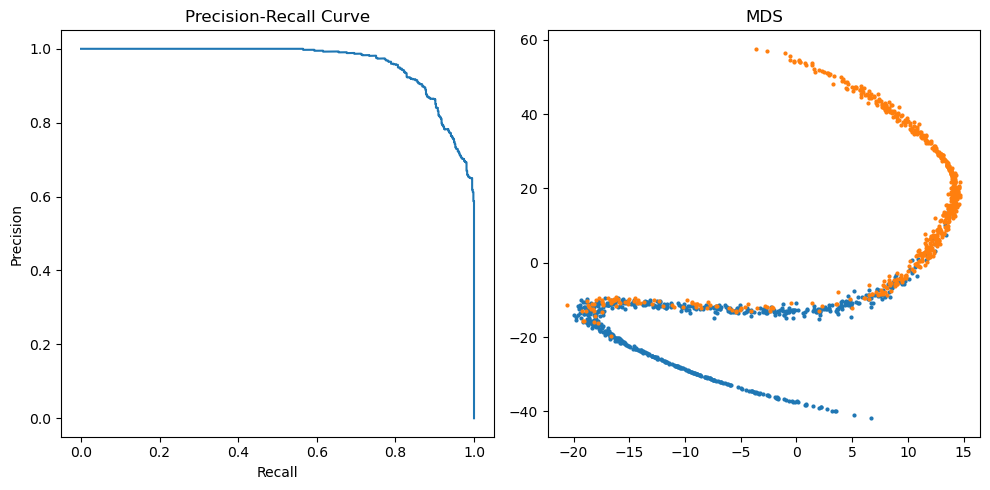

In [782]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Precision-Recall Curve")
plt.plot(np.concatenate(([1.0], recall)), np.concatenate(([0.0], precision)))
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.subplot(1, 2, 2)
plt.title("MDS")
plt.scatter(*bulk_points.T, s=4)
plt.scatter(*rhizosphere_points.T, s=4)

plt.tight_layout()

In [759]:
embeddings_flat = np.array(list(embeddings.values())).reshape((-1, 64))
embeddings_flat.shape

(1260, 64)

In [760]:
distance_matrix = cdist(embeddings_flat, embeddings_flat, metric="cityblock")
distance_matrix.shape

(1260, 1260)

In [761]:
mds_embeddings = MDS(dissimilarity="precomputed").fit_transform(distance_matrix)
mds_embeddings = mds_embeddings.reshape((len(embeddings), -1, 2))
mds_embeddings.shape

(126, 10, 2)

In [762]:
bulk_points = mds_embeddings[np.array([i for i, name in enumerate(embeddings) if '-B-' in name])].reshape((-1, mds_embeddings.shape[-1]))
rhizosphere_points = mds_embeddings[np.array([i for i, name in enumerate(embeddings) if '-R-' in name])].reshape((-1, mds_embeddings.shape[-1]))
bulk_points.shape, rhizosphere_points.shape

((630, 2), (630, 2))

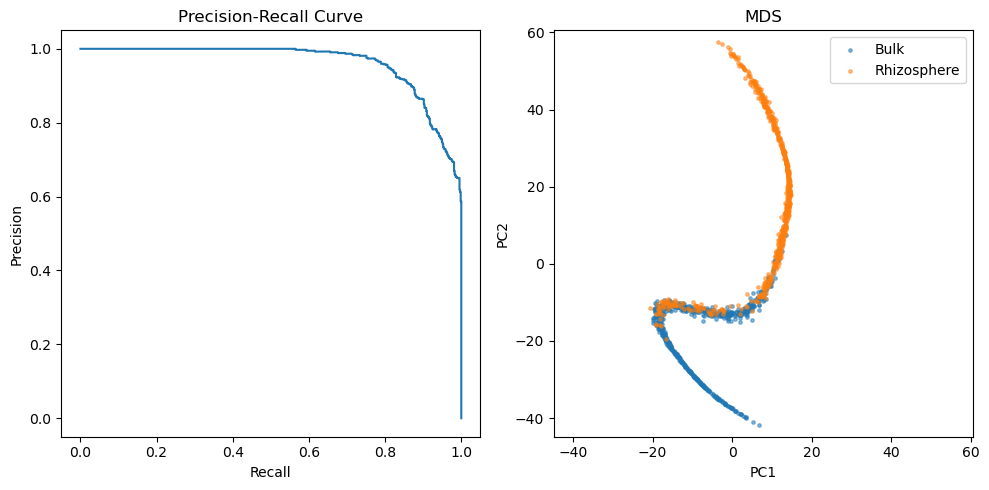

In [789]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Precision-Recall Curve")
plt.plot(np.concatenate(([1.0], recall)), np.concatenate(([0.0], precision)))
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.subplot(1, 2, 2)
plt.title("MDS")

plt.scatter(*bulk_points.T, s=6, alpha=0.5, label="Bulk")
plt.scatter(*rhizosphere_points.T, s=6, alpha=0.5, label="Rhizosphere")
pad = 3
plt.xlim((np.min(mds_embeddings) - pad, np.max(mds_embeddings) + pad))
plt.ylim((np.min(mds_embeddings) - pad, np.max(mds_embeddings) + pad))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()

## Verification of Correspondence between Deltas and Attribution Scores

In [429]:
sample_index = 3
a = load(samples[sample_index])

In [430]:
a["distance_deltas"]

array([[-7.5459480e-05,  6.7830086e-05],
       [-1.4042258e-03,  1.3151169e-03],
       [-3.1054020e-05,  2.5689602e-05],
       [-8.6015463e-04,  8.4590912e-04],
       [-1.1110306e-04,  1.0377169e-04],
       [-7.7509880e-04,  7.4535608e-04],
       [-4.5663118e-04,  4.4113398e-04],
       [-8.0662966e-04,  7.6770782e-04],
       [-1.2814999e-04,  1.1533499e-04],
       [-7.7486038e-05,  6.9737434e-05]], dtype=float32)

In [431]:
target = int('-R-' in samples[sample_index].name)
target

1

In [432]:
index = 0

In [433]:
scores = np.sum(a["scores"][:,:,1:], axis=(1, 2))[:,1:]
score_indices = np.argsort(scores[index])[np.linspace(0, scores.shape[1] - 1, 100).astype(int)]
sampled_scores = scores[index][score_indices]

In [434]:
predictions = []
for i in tqdm(score_indices):
    predictions.append(model(np.delete(a["sequences"][index][None,:], i, axis=1)).numpy().flatten()[0])
predictions = np.array(predictions)

100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


In [435]:
base = model(a["sequences"][index][None,:]).numpy().flatten()[0]
base

0.99836475

In [436]:
# delta = np.abs(target - predictions) - np.abs(target - base)
# delta[0], delta[-1]
delta = predictions - base
np.max(np.abs(delta))

7.545948e-05

High attribution (positive gradients) is pushing the output classification prediction up (moving the delta away from 0)

When the target label is 0, removing sequences with the highest attribution scores tends to improve performance.<br>
When the target label is 1, removing sequences with the lowest attribution scores tends to improve performance.

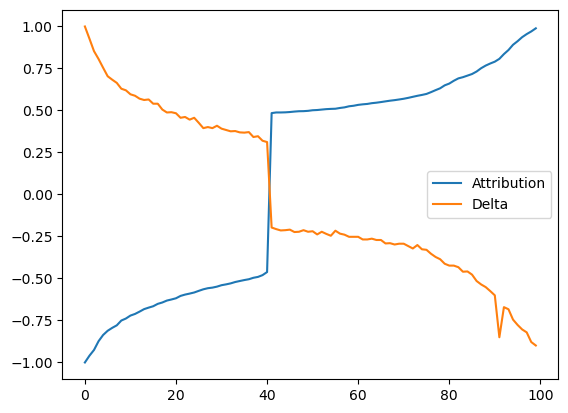

In [437]:
# indices = np.argsort(delta)
# Delta goes right (towards 1) when removing a low attribution value
# Delta goes left (towards 0) when removing a high attribution value
plt.plot(sampled_scores / np.max(np.abs(sampled_scores)), label="Attribution")
plt.plot(delta / np.max(np.abs(delta)), label="Delta")
plt.legend()

In [438]:
print("Attribution value guides delta direction.")
n = 0
for sample_index in range(len(samples)):
    a = load(samples[sample_index])
    target = int('-R-' in samples[sample_index].name)
    n += int(target == int(np.mean(np.sign(a["distance_deltas"][:,0])) < 0))
print("Correlation:", f"{n / len(samples):%}")

Attribution value guides delta direction.
Correlation: 93.750000%


## Attribution Scores Associated with Taxa

In [465]:
output_path = Path("/home/data2/deepdna/logs/hopland/attribution")
output_path.mkdir(exist_ok=True, parents=True)

In [514]:
for s in tqdm(samples):
    npz = load(s)
    fasta_ids = npz["fasta_ids"]
    scores = npz["scores"]
    scores = np.sum(scores[:,:,1:,1:], axis=(1, 2)) # sum across layers and rows (exclude class token)
    taxa_abundance = {}
    taxa_scores = {}
    subsamples = len(fasta_ids)
    for ids, scores_by_id in zip(fasta_ids, scores):
        for sequence_id, score in zip(ids, scores_by_id):
            label = taxonomy_labels[sequence_id]
            if label not in taxa_scores:
                taxa_abundance[label] = 0
                taxa_scores[label] = 0.0
            taxa_abundance[label] += 1
            taxa_scores[label] += score
    labels = list(taxa_abundance.keys())
    np.savez(output_path / f"{s.name}.result.npz",
        labels=labels,
        taxa_abundance=np.array([taxa_abundance[k] for k in labels]),
        taxa_scores=np.array([taxa_scores[k] for k in labels]))

100%|██████████| 128/128 [00:27<00:00,  4.65it/s]


In [540]:
bulk_samples = [s for s in clean_samples if '-B-' in s.name]
rhizosphere_samples = [s for s in clean_samples if '-R-' in s.name]

In [537]:
# Bulk = 0
# Negative attribution scores are of interest.
attribution_info = {}
for s in tqdm(clean_samples):
    npz = np.load(output_path / f"{s.name}.result.npz", allow_pickle=True)
    labels = npz["labels"]
    taxa_scores = npz["taxa_scores"]
    taxa_abundance = npz["taxa_abundance"]
    for label, abundance, score in zip(labels, taxa_abundance, taxa_scores):
        if label not in attribution_info:
            attribution_info[label] = (0, 0)
        old_abundance, old_score = attribution_info[label]
        attribution_info[label] = (old_abundance + abundance, old_score + score)

100%|██████████| 126/126 [00:00<00:00, 321.09it/s]


In [555]:
attribution_scores = []
for label, (abundance, score) in attribution_info.items():
    attribution_scores.append({
        **dict(zip(taxonomy.RANKS, taxonomy.split_taxonomy(label))),
        "Abundance": abundance,
        "Total Attribution Score": score
    })
attribution_scores.sort(key=lambda x: x["Total Attribution Score"], reverse=True)
attribution_scores = pd.DataFrame(attribution_scores)
attribution_scores.to_csv("/home/data2/deepdna/logs/hopland/taxa_attribution_scores.csv")
attribution_scores[:50]

,Domain,Phylum,Class,Order,Family,Genus,Species,Abundance,Total Attribution Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,uncultured_low,42137,11642.633733
1,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,uncultured_organism,27414,7640.367994
2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus_mesonae,24615,6909.415661
3,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus_niacini,21236,5980.892275
4,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,uncultured_Sphingomonadaceae,12187,4002.962545
5,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Chthoniobacterales,Chthoniobacteraceae,Candidatus_Udaeobacter,uncultured_Prosthecobacter,8801,3036.733642
6,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,uncultured,uncultured_bacterium,5374,2678.872121
7,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus_aryabhattai,7677,2073.793505
8,Bacteria,Acidobacteriota,Acidobacteriae,Bryobacterales,Bryobacteraceae,Bryobacter,uncultured_bacterium,5137,1483.164273
9,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Segetibacter,uncultured_Segetibacter,3640,1468.576710


In [556]:
attribution_scores[-50:]

,Domain,Phylum,Class,Order,Family,Genus,Species,Abundance,Total Attribution Score
10921,Bacteria,Acidobacteriota,Subgroup_5,Subgroup_5,Subgroup_5,Subgroup_5,uncultured_bacterium,2639,-857.866589
10922,Bacteria,Actinobacteriota,Thermoleophilia,uncultured,uncultured,uncultured,uncultured_bacterium,2384,-868.252668
10923,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,uncultured,uncultured_bacterium,2564,-870.982704
10924,Bacteria,Acidobacteriota,Blastocatellia,Pyrinomonadales,Pyrinomonadaceae,RB41,metagenome,2586,-873.743365
10925,Bacteria,Gemmatimonadota,Gemmatimonadetes,Gemmatimonadales,Gemmatimonadaceae,Gemmatimonas,uncultured_Gemmatimonadaceae,2988,-875.177275
10926,Archaea,Crenarchaeota,Nitrososphaeria,Nitrososphaerales,Nitrososphaeraceae,Nitrososphaeraceae,metagenome,2829,-885.555249
10927,Bacteria,Actinobacteriota,Rubrobacteria,Rubrobacterales,Rubrobacteriaceae,Rubrobacter,uncultured_Rubrobacter,2577,-908.771005
10928,Bacteria,Acidobacteriota,Vicinamibacteria,Vicinamibacterales,uncultured,uncultured,uncultured_Acidobacteriales,2862,-931.485521
10929,Bacteria,Planctomycetota,Phycisphaerae,Tepidisphaerales,WD2101_soil_group,WD2101_soil_group,uncultured_soil,2524,-932.202545
10930,Bacteria,Myxococcota,Polyangia,Haliangiales,Haliangiaceae,Haliangium,uncultured_Myxococcales,2205,-935.445780


In [551]:
# Bulk = 0
# Negative attribution scores are of interest.
bulk_attribution_info = {}
for s in tqdm(bulk_samples):
    npz = np.load(output_path / f"{s.name}.result.npz", allow_pickle=True)
    labels = npz["labels"]
    taxa_scores = -npz["taxa_scores"]
    taxa_abundance = npz["taxa_abundance"]
    for label, abundance, score in zip(labels, taxa_abundance, taxa_scores):
        if label not in bulk_attribution_info:
            bulk_attribution_info[label] = (0, 0)
        old_abundance, old_score = bulk_attribution_info[label]
        bulk_attribution_info[label] = (old_abundance + abundance, old_score + score)

100%|██████████| 63/63 [00:00<00:00, 327.27it/s]


In [552]:
bulk_attribution_scores = []
for label, (abundance, score) in bulk_attribution_info.items():
    bulk_attribution_scores.append({
        **dict(zip(taxonomy.RANKS, taxonomy.split_taxonomy(label))),
        "Abundance": abundance,
        "Total Attribution Score": score
    })
bulk_attribution_scores.sort(key=lambda x: x["Total Attribution Score"], reverse=True)
bulk_attribution_scores = pd.DataFrame(bulk_attribution_scores)
bulk_attribution_scores.to_csv("/home/data2/deepdna/logs/hopland/taxa_attribution_scores_bulk.csv")
bulk_attribution_scores

,Domain,Phylum,Class,Order,Family,Genus,Species,Abundance,Total Attribution Score
0,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,67-14,uncultured_bacterium,7740,2879.239003
1,Bacteria,Acidobacteriota,Vicinamibacteria,Vicinamibacterales,uncultured,uncultured,uncultured_bacterium,8034,2696.999311
2,Bacteria,Planctomycetota,Planctomycetes,Gemmatales,Gemmataceae,uncultured,uncultured_bacterium,7885,2592.994195
3,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,67-14,uncultured_actinobacterium,6068,2286.591236
4,Bacteria,Gemmatimonadota,Gemmatimonadetes,Gemmatimonadales,Gemmatimonadaceae,uncultured,uncultured_Gemmatimonadales,5998,1933.546365
...,...,...,...,...,...,...,...,...,...
8133,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,uncultured_Sphingomonadaceae,7330,-2504.180532
8134,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus_niacini,9650,-3078.549769
8135,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus_mesonae,11523,-3630.480770
8136,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,uncultured_organism,12057,-3802.851400


In [553]:
# Rhizosphere = 1
# Positive attribution scores are of interest.
rhizosphere_attribution_info = {}
for s in tqdm(rhizosphere_samples):
    npz = np.load(output_path / f"{s.name}.result.npz", allow_pickle=True)
    labels = npz["labels"]
    taxa_scores = npz["taxa_scores"]
    taxa_abundance = npz["taxa_abundance"]
    for label, abundance, score in zip(labels, taxa_abundance, taxa_scores):
        if label not in rhizosphere_attribution_info:
            rhizosphere_attribution_info[label] = (0, 0)
        old_abundance, old_score = rhizosphere_attribution_info[label]
        rhizosphere_attribution_info[label] = (old_abundance + abundance, old_score + score)

100%|██████████| 63/63 [00:00<00:00, 291.57it/s]


In [554]:
rhizosphere_attribution_scores = []
for label, (abundance, score) in rhizosphere_attribution_info.items():
    rhizosphere_attribution_scores.append({
        **dict(zip(taxonomy.RANKS, taxonomy.split_taxonomy(label))),
        "Abundance": abundance,
        "Total Attribution Score": score
    })
rhizosphere_attribution_scores.sort(key=lambda x: x["Total Attribution Score"], reverse=True)
rhizosphere_attribution_scores = pd.DataFrame(rhizosphere_attribution_scores)
rhizosphere_attribution_scores.to_csv("/home/data2/deepdna/logs/hopland/taxa_attribution_scores_rhizosphere.csv")
rhizosphere_attribution_scores

,Domain,Phylum,Class,Order,Family,Genus,Species,Abundance,Total Attribution Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,uncultured_low,23066,5670.476048
1,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,uncultured_organism,15357,3837.516594
2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus_mesonae,13092,3278.934891
3,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus_niacini,11586,2902.342507
4,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,uncultured_Sphingomonadaceae,4857,1498.782013
...,...,...,...,...,...,...,...,...,...
9289,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Bradyrhizobium,Bradyrhizobium_japonicum,3755,-1392.807203
9290,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,67-14,uncultured_bacterium,4481,-1416.020941
9291,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Microvirga,Microvirga_flocculans,6380,-1607.431973
9292,Bacteria,Planctomycetota,Planctomycetes,Gemmatales,Gemmataceae,uncultured,uncultured_bacterium,6036,-1611.562468


---

## Sequence Importance Analysis

In [10]:
sample_index = 0
sample_name = samples[sample_index].name
bulk_rhizosphere = int('-R-' in sample_name)
sample_name, bulk_rhizosphere

('Ur1-B-16S_S197_L001_R1_001', 0)

In [11]:
sequences, fasta_ids = dg.BatchGenerator(1, 1, [
    dg.random_fasta_samples([samples[sample_index]]),
    dg.random_sequence_entries(1000),
    dg.sequences(150),
    dg.encode_sequences(),
    dg.augment_ambiguous_bases,
    dg.encode_kmers(3),
    lambda encoded_kmer_sequences, sequence_entries: (encoded_kmer_sequences, dg.recursive_map(lambda e: e.identifier, sequence_entries))
])[0]

In [29]:
attr_scores = attribution(sequences)[0]

Using new attention


In [38]:
attr_scores = np.sum(attr_scores, axis=1)

In [43]:
attr_scores /= np.max(attr_scores, axis=(1, 2), keepdims=True)

In [46]:
attr_scores.shape

(8, 1001, 1001)

In [59]:
scores = np.sum(attr_scores, axis=(0, 1))[1:]
scores_cls = np.sum(attr_scores[:,0,1:], axis=0)
scores_elems = np.sum(attr_scores[:,1:,1:], axis=(0, 1))

In [15]:
predictions = []
for i in tqdm(range(sequences.shape[1])):
    predictions.append(model(np.delete(sequences, i, axis=1)).numpy().flatten())
predictions = np.array(predictions)

100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


In [60]:
base = model(sequences).numpy().flatten()[0]

In [61]:
deltas = (np.abs(bulk_rhizosphere - predictions) - np.abs(bulk_rhizosphere - base)).flatten()

In [62]:
indices = np.argsort(scores)[::-1]
indices_cls = np.argsort(scores_cls)[::-1]
indices_elems = np.argsort(scores_elems)[::-1]
indices_deltas = np.argsort(deltas)

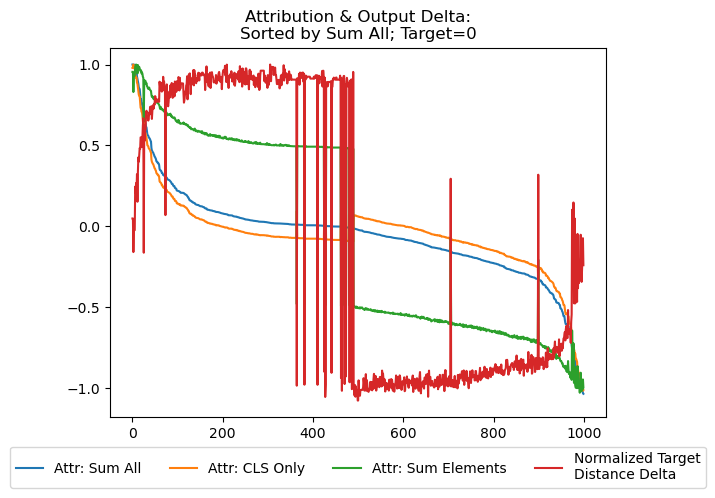

In [63]:
plt.title(f"Attribution & Output Delta:\nSorted by Sum All; Target={bulk_rhizosphere}")
plt.plot(normalized(scores[indices]), label="Attr: Sum All")
plt.plot(normalized(scores_cls[indices]), label="Attr: CLS Only")
plt.plot(normalized(scores_elems[indices]), label="Attr: Sum Elements")
plt.plot(normalized(deltas[indices]), label="Normalized Target\nDistance Delta")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.21), ncol=4)

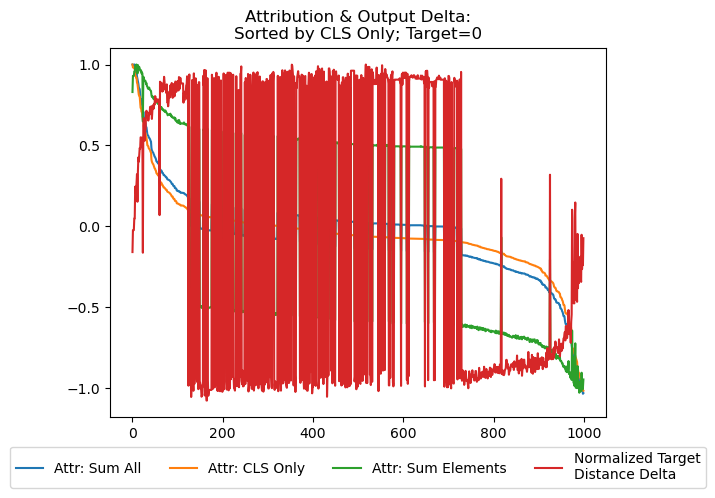

In [64]:
plt.title(f"Attribution & Output Delta:\nSorted by CLS Only; Target={bulk_rhizosphere}")
plt.plot(normalized(scores[indices_cls]), label="Attr: Sum All")
plt.plot(normalized(scores_cls[indices_cls]), label="Attr: CLS Only")
plt.plot(normalized(scores_elems[indices_cls]), label="Attr: Sum Elements")
plt.plot(normalized(deltas[indices_cls]), label="Normalized Target\nDistance Delta")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.21), ncol=4)

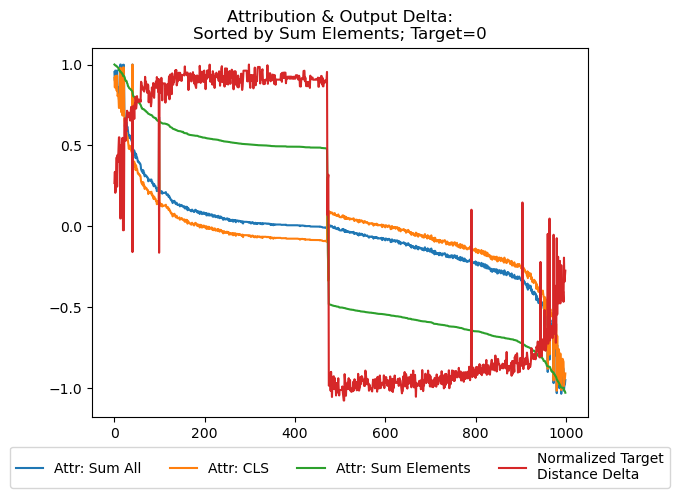

In [65]:
plt.title(f"Attribution & Output Delta:\nSorted by Sum Elements; Target={bulk_rhizosphere}")
plt.plot(normalized(scores[indices_elems]), label="Attr: Sum All")
plt.plot(normalized(scores_cls[indices_elems]), label="Attr: CLS")
plt.plot(normalized(scores_elems[indices_elems]), label="Attr: Sum Elements")
plt.plot(normalized(deltas[indices_elems]), label="Normalized Target\nDistance Delta")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.21), ncol=4)

Text(0, 0.5, 'Normalized ATTR Score/\nNormalized Target Delta Distance')

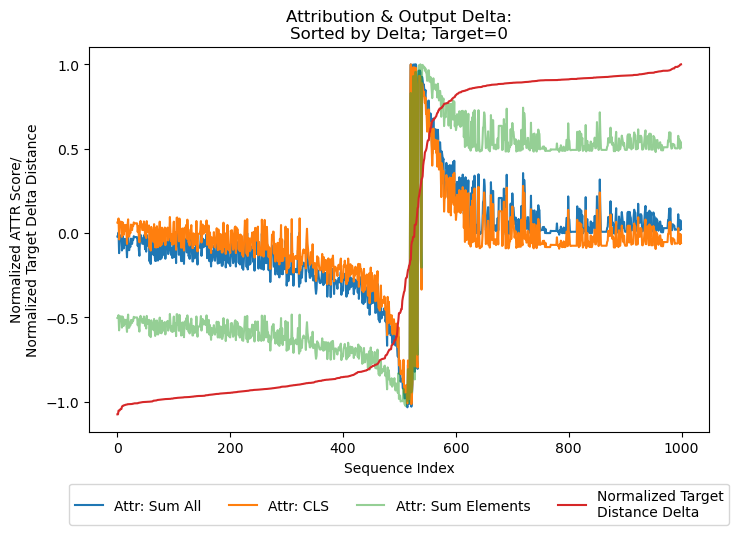

In [66]:
plt.figure(figsize=(8, 5))
plt.title(f"Attribution & Output Delta:\nSorted by Delta; Target={bulk_rhizosphere}")
plt.plot(normalized(scores[indices_deltas]), label="Attr: Sum All")
plt.plot(normalized(scores_cls[indices_deltas]), label="Attr: CLS")
plt.plot(normalized(scores_elems[indices_deltas]), label="Attr: Sum Elements", alpha=0.5)
plt.plot(normalized(deltas[indices_deltas]), label="Normalized Target\nDistance Delta")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.26), ncol=4)
plt.xlabel("Sequence Index")
plt.ylabel("Normalized ATTR Score/\nNormalized Target Delta Distance")

## Consistency

In [67]:
predictions_by_group = {
    "scores": [],
    "scores_cls": [],
    "scores_elems": []
}

In [70]:
for sample_index in tqdm(range(len(samples))):
    sample_name = samples[sample_index].name
    bulk_rhizosphere = int('-R-' in sample_name)

    if sample_index < len(predictions_by_group["scores"]):
        continue

    sequences, fasta_ids = dg.BatchGenerator(1, 1, [
        dg.random_fasta_samples([samples[sample_index]]),
        dg.random_sequence_entries(1000),
        dg.sequences(150),
        dg.encode_sequences(),
        dg.augment_ambiguous_bases,
        dg.encode_kmers(3),
        lambda encoded_kmer_sequences, sequence_entries: (encoded_kmer_sequences, dg.recursive_map(lambda e: e.identifier, sequence_entries))
    ])[0]

    attr_scores = attribution(sequences)[0]
    attr_scores /= np.max(attr_scores, axis=(1, 2, 3), keepdims=True)
    scores = np.sum(attr_scores, axis=(0, 1, 2))[1:]
    scores_cls = np.sum(attr_scores, axis=(0, 1))[0][1:]
    scores_elems = np.sum(attr_scores[:,:,1:,1:], axis=(0, 1, 2))

    base = model(sequences).numpy().flatten()[0]

    for pred_group, score_group in zip(predictions_by_group.values(), (scores, scores_cls, scores_elems)):
        score_min = np.min(score_group)
        score_max = np.max(score_group)
        pred_min = model(np.delete(sequences, np.argmin(score_group), axis=1)).numpy().flatten()[0]
        pred_max = model(np.delete(sequences, np.argmax(score_group), axis=1)).numpy().flatten()[0]

        delta_min, delta_max = (np.abs(bulk_rhizosphere - np.array((pred_min, pred_max))) - np.abs(bulk_rhizosphere - base)).flatten()

        pred_group.append(((score_min, score_max), (delta_min, delta_max)))

  0%|          | 0/128 [00:00<?, ?it/s]

Using new attention


  2%|▏         | 3/128 [00:15<10:25,  5.00s/it]

Using new attention


  3%|▎         | 4/128 [00:30<17:01,  8.24s/it]

Using new attention


  4%|▍         | 5/128 [00:45<21:19, 10.40s/it]

Using new attention


  5%|▍         | 6/128 [01:00<24:06, 11.86s/it]

Using new attention


  5%|▍         | 6/128 [01:12<24:38, 12.12s/it]


KeyboardInterrupt: 

In [71]:
for group_name, group in predictions_by_group.items():
    sign_correlations = 0
    num_sign_changes = 0
    for ((score_min, score_max), (delta_min, delta_max)) in group:
        sign_correlations += int(np.sign(score_min) == np.sign(delta_min))
        num_sign_changes += int(np.sign(delta_min) != np.sign(delta_max))
    print(group_name)
    print('  Attribution & Delta: Same Sign Correlation', f"{sign_correlations / len(group):%}")
    print('  Attribution & Delta: Sign Correlation', f"{num_sign_changes / len(group):%}")


scores
  Attribution & Delta: Same Sign Correlation 50.000000%
  Attribution & Delta: Sign Correlation 100.000000%
scores_cls
  Attribution & Delta: Same Sign Correlation 50.000000%
  Attribution & Delta: Sign Correlation 100.000000%
scores_elems
  Attribution & Delta: Same Sign Correlation 50.000000%
  Attribution & Delta: Sign Correlation 100.000000%
